# RP3xFlow Ensemble

## Introduction
Volatility targeted ensemble, including:

- Risk premia harvesting strategy
- Turn-of-month flow strategies

Asset universe, including:

- Equity ETF e.g. $VTI
- Bond ETF e.g. $TLT
- Commodity ETF e.g. $GLD

## Part 1: Define imports and strategy parameters

In [4]:
import datetime
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Map asset class to instrument
equity_ticker = 'VDNR.L'
bond_ticker = 'IBTL.L'
gold_ticker = 'SGLN.L'
universe_tickers = [equity_ticker, bond_ticker, gold_ticker]

# Assetwise volatility targets
equity_vol_target = 0.03
bond_vol_target = 0.03
gold_vol_target = 0.03

# Portfolio re-balance threshold at % of vol target
rebalance_vol_threshold = 0.2

# Calendar days to load data for each asset class
hist_price_period_days = 5 * 365

# Day periods to use for volatility estimation
vol_forecast_period_days = 60

# Portfolio positions used to calculate NAV and order deltas
cash_value = 1000
equity_pf_qty = 10
bond_pf_qty = 0
gold_pf_qty = 0

## Part 2: Load asset universe data

Load historic adjusted close prices for our universe for last x days.

In [5]:
# Set period to load data, noting these are calendar days not trading days
period = datetime.datetime.utcnow()
period_start = period - datetime.timedelta(days=hist_price_period_days)

# Get daily adjusted close data from Yahoo Finance for our universe
asset_df = pdr.get_data_yahoo(universe_tickers, start=period_start, end=period)[['Adj Close']]

# Standardize names
asset_df = asset_df.reset_index()
asset_df = asset_df.rename_axis(columns={'Attributes': 'attribute', 'Symbols': 'ticker'})
asset_df = asset_df.rename(columns={'Date': 'date', 'Adj Close': 'price'})

# Save price data to local feather file
feather_prep_df = asset_df.copy()
feather_prep_df.columns = feather_prep_df.columns.map(str)
feather_prep_df.to_feather("./prices.feather")

asset_df.tail(5)


attribute       date       price                    
ticker                    VDNR.L      IBTL.L  SGLN.L
1258      2022-08-17  104.230003  353.149994  2853.0
1259      2022-08-18  104.544998  356.899994  2860.0
1260      2022-08-19  103.157501  354.649994  2885.0
1261      2022-08-22  101.510002  354.299988  2875.5
1262      2022-08-23  101.040001  354.549988  2878.5

## Part 3: Enrich our asset data

Calculate and visualize derived metrics such as total returns and rolling volatility.

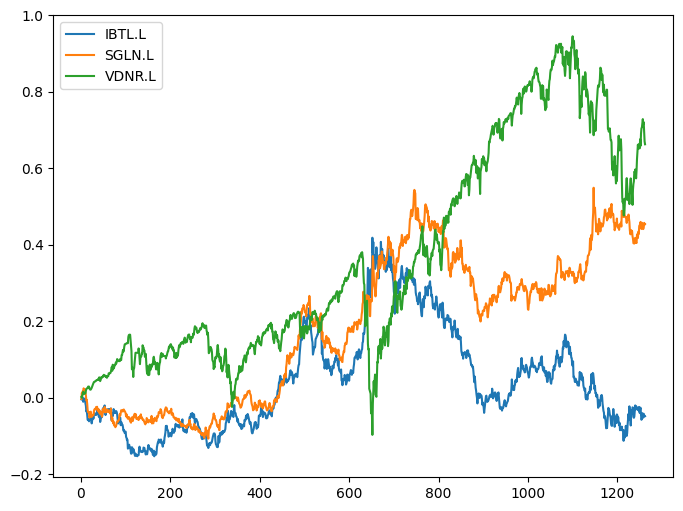

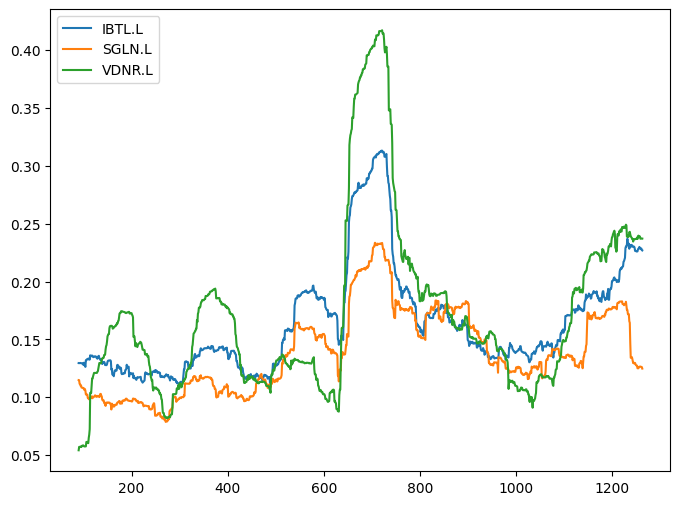

In [6]:
for ticker in universe_tickers:
    # Calculate total returns
    asset_df['return', ticker] = asset_df['price', ticker].pct_change()
    asset_df['log_return', ticker] = np.log(asset_df['price', ticker]/asset_df['price', ticker].shift(1))
    asset_df['cum_return', ticker] = (1 + asset_df['return', ticker]).cumprod() - 1
    asset_df['cum_log_return', ticker] = asset_df['log_return', ticker].cumsum()

    # Calculate rolling annual volatility for key periods
    asset_df['rolling_xd_ann_vol', ticker] = asset_df['log_return', ticker].rolling(vol_forecast_period_days).std() * math.sqrt(252)
    asset_df['rolling_30d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(30).std() * math.sqrt(252)
    asset_df['rolling_60d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(60).std() * math.sqrt(252)
    asset_df['rolling_90d_ann_vol', ticker] = asset_df['log_return', ticker].rolling(90).std() * math.sqrt(252)

asset_df = asset_df.sort_index(axis='columns', level=1)

asset_df['cum_return'].plot(figsize=(8,6))
plt.legend(loc=2)

asset_df['rolling_90d_ann_vol'].plot(figsize=(8, 6))
plt.legend(loc=2)


## Part 4: Evaluate portfolio

Compute target position sizes based on annualized volatility.

In [15]:
# Get latest day data as a series
latest_ds = asset_df.iloc[-1]

# Select latest prices to calculate portfolio NAV
equity_price = latest_ds['price', equity_ticker]
bond_price = latest_ds['price', bond_ticker]
gold_price = latest_ds['price', gold_ticker]
portfolio_nav = cash_value + (equity_pf_qty * equity_price) + (bond_pf_qty * bond_price) + (gold_pf_qty * gold_price)

# Build dataframe of portfolio positions
portfolio_df = pd.DataFrame({'ticker': universe_tickers})
portfolio_df['date'] = latest_ds['date', '']
portfolio_df['price'] = [equity_price, bond_price, gold_price]
portfolio_df['vol'] = [
        latest_ds['rolling_xd_ann_vol', equity_ticker],
        latest_ds['rolling_xd_ann_vol', bond_ticker],
        latest_ds['rolling_xd_ann_vol', gold_ticker]]
portfolio_df['vol_target'] = [equity_vol_target, bond_vol_target, gold_vol_target]
portfolio_df['pf_qty'] = [equity_pf_qty, bond_pf_qty, gold_pf_qty]
portfolio_df['target_qty'] = (portfolio_df['vol_target'] / portfolio_df['vol']) * (portfolio_nav / portfolio_df['price'])
portfolio_df['delta_qty'] = (portfolio_df['target_qty'] - portfolio_df['pf_qty'])

portfolio_df


,ticker,date,price,vol,vol_target,pf_qty,target_qty,delta_qty
0,VDNR.L,2022-08-23,101.040001,0.226020,0.03,10,2.640965,-7.359035
1,IBTL.L,2022-08-23,354.549988,0.225401,0.03,0,0.754692,0.754692
2,SGLN.L,2022-08-23,2878.500000,0.120265,0.03,0,0.174221,0.174221
